In [1]:
# for plotting, run: pip install pandas matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

import wfdb
%pip install gluonts

from gluonts.dataset.pandas import PandasDataset
from chronos_mlx import ChronosPipeline
from chronos_utils import *

pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-mini",
    dtype="bfloat16",
)

Note: you may need to restart the kernel to use updated packages.


/Users/pm-w/Documents/Research/FoundationalModels/FL-GitHub/Time-Series/.venv/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/Users/pm-w/Documents/Research/FoundationalModels/FL-GitHub/Time-Series/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/pm-w/Documents/Research/FoundationalModels/FL-GitHub/Time-Series/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


['a100-0', 'a100-1', 'a100-2', 'a100-3', 'a100-4', 'a100-5', 'a100-6', 'a100-7', 'a100-8', 'a100-9']


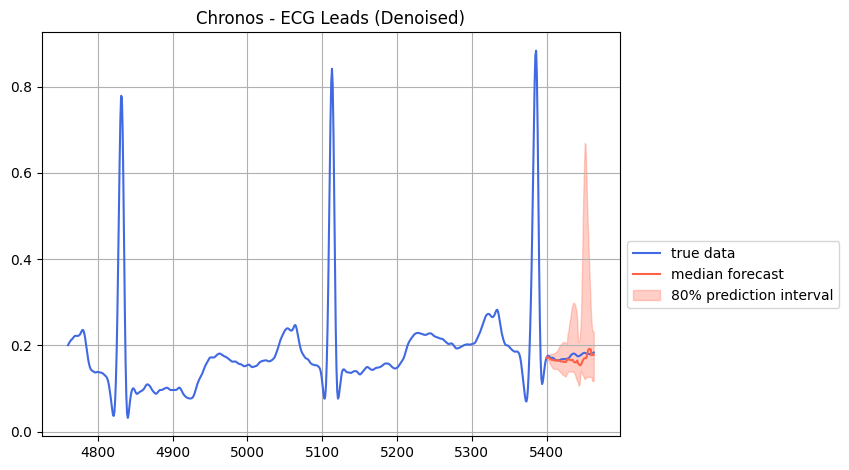

In [26]:
npz_path = '../data/MIT-BIH/MIT-BIH.npz'

with np.load(npz_path) as data:
    print(data.files[:10])
    MLII_df = data[data.files[2]]

# plt.plot(range(len(MLII_df)),MLII_df)
    
    context_length = 640
    prediction_length = 64
    ts_full = MLII_df[-(context_length + prediction_length):]

    context = MLII_df[-(context_length + prediction_length):-prediction_length]

    forecast_index = range(len(MLII_df)-64, len(MLII_df))

    forecast = pipeline.predict(
        context,
        prediction_length,
        num_samples=20,
        temperature=1.0,
        top_k=100,
        top_p=1,
    ) # forecast shape: [num_series, num_samples, prediction_length]


    low, median, high = np.quantile(forecast[0], [0.1, 0.5, 0.9], axis=0)

    result_df = pd.DataFrame(data = {'low':low, 'median':median, 'high':high}, index = forecast_index)

    fig, ax = plt.subplots()

ax.plot(range(len(MLII_df) - len(ts_full), len(MLII_df)), ts_full, color="royalblue", label="true data")
ax.plot(forecast_index, result_df['median'], color="tomato", label="median forecast")
ax.fill_between(forecast_index, result_df['low'], result_df['high'], color="tomato", alpha=0.3, label="80% prediction interval")
ax.set_title('MLII')    

ax.grid()

plt.tight_layout()
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
plt.title('Chronos - ECG Leads (Denoised)')
plt.show()